# Minimal Implementation for Dynamics of Specialization

In [93]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [2]:
%load_ext autoreload
%autoreload 2

## Data

### Generate

In [3]:
from dynspec.datasets import get_datasets
from dynspec.data_process import process_data

In [36]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 512

In [65]:
n_agents = 2
n_classes_per_digit = 10
n_classes = n_classes_per_digit * n_agents
nb_steps = 2

data_config = {
    # ------ Change if needed------
    "batch_size": 512,
    "input_size": 28,
    "use_cuda": use_cuda,
    "data_type": "double_digits",
    "n_digits": n_agents,
    "n_classes": n_classes,
    "n_classes_per_digit": n_classes_per_digit,
    "nb_steps": nb_steps,
    "common_input": True,
    "cov_ratio": 1,
    "noise_ratio": 0.5,
    "random_start": False,
    # ------ Leave as is -------
    "data_size": None,
    "fix_asym": True,
    "permute_dataset": False,
    "split_classes": True,
    "seed": np.random.randint(100),
    # --------------------------

}

In [38]:
all_data = get_datasets("../data/", data_config)
datasets, loaders = all_data[data_config["data_type"]]

KeyboardInterrupt: 

### Plot

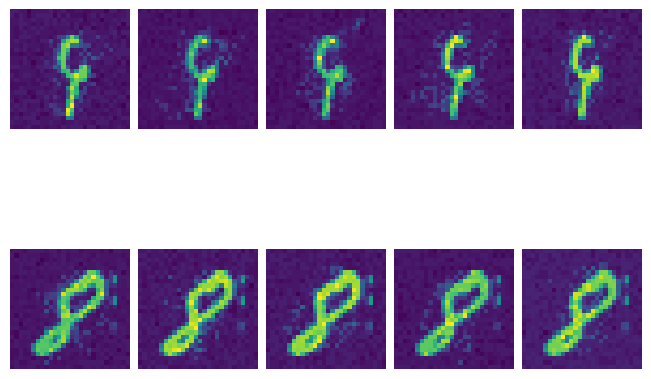

In [39]:
data, target = next(iter(loaders[0]))
temporal_data, _ = process_data(data, data_config)
if data_config["common_input"]:
    temporal_data = torch.stack(
        temporal_data.split(temporal_data.shape[-1] // n_agents, -1), 1
    )

fig, axs = plt.subplots(n_agents, temporal_data.shape[0], constrained_layout=True)
for t_data, t_axs in zip(temporal_data, axs.T):
    for d, ax in zip(t_data, t_axs):
        ax.imshow(d[0].cpu().numpy().reshape(28, 28))
        ax.axis("off")

## Init Models

In [66]:
from dynspec.models import masked_GRU, masked_RNN, Community

In [104]:
task = "parity-digits-sum"

agents_config = {
    "n_agents": 2,
    "hidden_size": 50,
    "n_layers": 1,
    "dropout": 0.25,
    "cell_type": str(masked_GRU),
}

n_conns = 1
connections_config = {"sparsity": n_conns / agents_config["hidden_size"] ** 2}

n_outs = {
    "parity-digits": 10,
    "parity-digits-sum": 2,
    "sum": 20,
    "bitxor": 16,
    "bitxor-last-1": 2,
}

input_config = {"input_size": data_config["input_size"] ** 2, "common_input": False}
optim_config = {"lr": 1e-3, "weight_decay": 1e-4}

readout_config = {
    "output_size": n_outs[task],
    "common_readout": False,
}

decision = ["last", "max"]

model = Community(agents_config, connections_config, input_config, readout_config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), **optim_config)

/home/gb21/.conda/envs/dynspec/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


## Training

In [105]:
from dynspec.training import train_community, get_acc
from dynspec.decision import get_decision
from dynspec.tasks import get_task_target

In [106]:
data, target = next(iter(loaders[1]))
data, _ = process_data(data, data_config)
data = data.to(device)
out, states = model(data)
out.shape, states.shape # (nb_steps x n_agents (if not common readout) x batch_size x out_size), (n_layers x bacth_size x n_agents x hidden_size)

(torch.Size([2, 2, 512, 2]), torch.Size([1, 512, 100]))

In [107]:
output, _ = get_decision(out, *decision)
t_target = get_task_target(target, task, data_config["n_classes_per_digit"]).to(device)
get_acc(output, t_target)

array(0.453125, dtype=float32)

In [108]:
training_config = {
    "n_epochs": 70,
    "task": task,
}

config = {
    "agents": agents_config,
    "connections": connections_config,
    "input": input_config,
    "readout": readout_config,
    "data": data_config,
    "decision": decision,
    "training": training_config,
}

In [109]:
train_results = train_community(model, *loaders, optimizer, config, stop_acc=0.95, device=device)

Train Epoch::   0%|          | 0/71 [00:00<?, ?it/s]

### Results

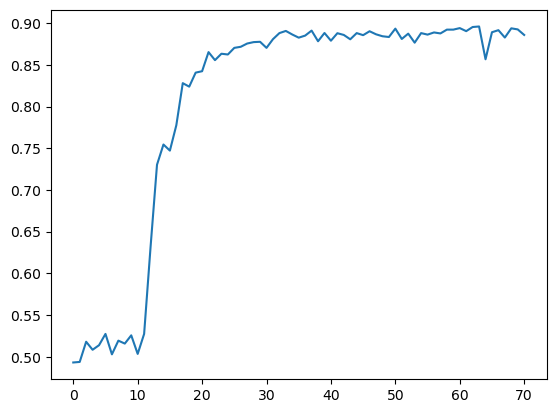

In [110]:
plt.plot(train_results["test_accs"])

In [ ]:
raise StopIteration

StopIteration: 

### Analysis

In [111]:
data, target = next(iter(loaders[1]))
data, _ = process_data(data, data_config)
data.shape
out, states = model(data.to(device))
out.shape, states.shape
t_target = get_task_target(target, task, data_config["n_classes_per_digit"])

In [112]:
comms_sent = states[
    ...,
    (model.comms_mask.split(100, 0)[0] * (1 - model.state_mask.split(100, 0)[0]))
    .to(bool)
    .any(1),
][-1]
comms_received = states[
    ...,
    (model.comms_mask.split(100, 0)[0] * (1 - model.state_mask.split(100, 0)[0]))
    .to(bool)
    .any(0),
][-1]

In [113]:
comms_sent.shape

torch.Size([512, 2])

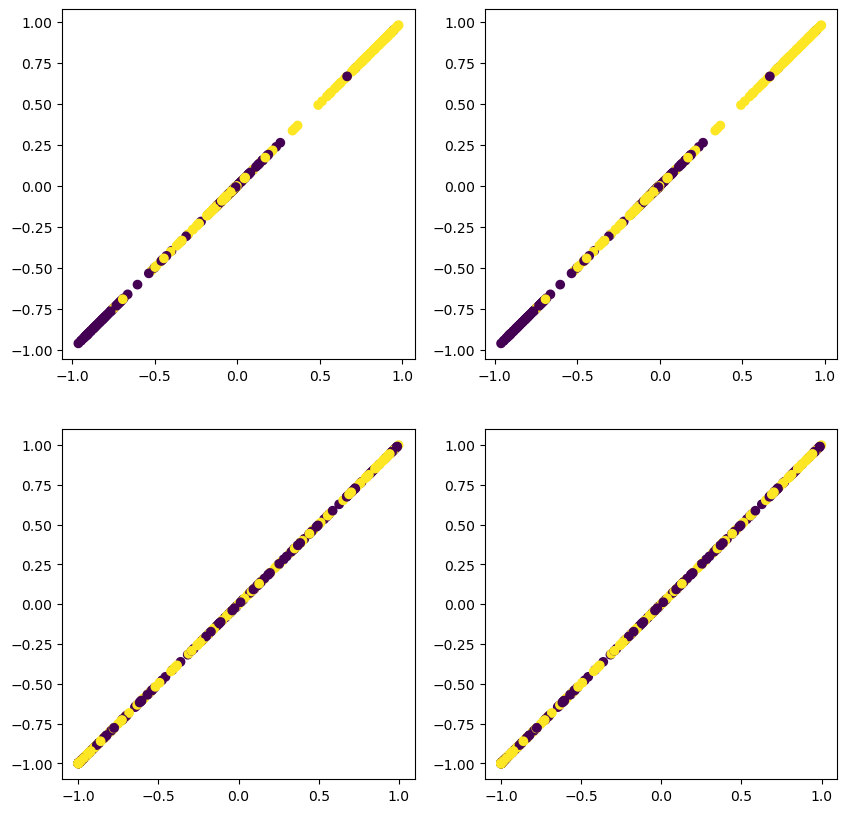

In [114]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
try : 
    axs[0]
except TypeError:
    axs = np.array([axs])
for comms, axs_c in zip([comms_sent, comms_received], axs):
    try : 
        axs_c[0]
    except TypeError:
        axs_c = np.array([axs_c])
    for (i, j), ax in zip(product(range(2), repeat=2), axs_c.flatten()):
        try:
            ax.scatter(
                comms[:, 2 * i].cpu().data.numpy(),
                comms[:, 2 * i ].cpu().data.numpy(),
                c=t_target,
            )
        except IndexError:
            ax.scatter(
                range(len(comms[:, i])), comms[:, i].cpu().data.numpy(), c=t_target
            )

## Metrics

### Retraining

In [ ]:
def readout_mask(n_agents, n_in, n_out, ag_to_mask=None):
    mask = torch.ones(n_agents).unsqueeze(0)
    if ag_to_mask is not None:
        mask[:, ag_to_mask] = 0
    mask = mask.repeat_interleave(n_out, 0).repeat_interleave(n_in, 1)
    # plt.imshow(mask)
    return mask


n_classes = config["data"]["n_classes_per_digit"]
n_targets = 2

def nested_shape(output):
    if hasattr(output, "shape"):
        return [output.shape]
    else:
        return [nested_shape(o) for o in output]


def reccursive_loss(output, target, loss_fn):
    try:
        out = loss_fn(output, target)

        # out = torch.stack(out)
    except (TypeError, RuntimeError) as e:
        out = [reccursive_loss(o, t, loss_fn) for o, t in zip(output, target)]

    return out


def reccursive_stack(input):
    try:
        return torch.stack(input)
    except TypeError:
        return torch.stack([reccursive_stack(i) for i in input])


model.readout = nn.ModuleList(
    [
        nn.ModuleList(
            [nn.Linear(model.n_agents * model.hidden_size, n_classes) for _ in range(3)]
        )
        for _ in range(n_targets)
    ]
)
for n, p in model.named_parameters():
    if not "readout" in n:
        p.requires_grad = False
model.register_buffer(
    "output_mask",
    torch.stack(
        [
            torch.stack(
                [
                    readout_mask(
                        model.n_agents, model.hidden_size, n_classes, ag_to_mask=i
                    )
                    for i in list(range(model.n_agents)) + [None]
                ]
            )
            for _ in range(n_targets)
        ]
    ),
)

In [ ]:
outs, _ = model(data)

In [ ]:
targets = [[[t for _ in range(2)] for _ in range(3)] for t in target.T]
reccursive_stack(targets).shape

torch.Size([2, 3, 2, 512])

In [ ]:
loss_fn = nn.CrossEntropyLoss(reduction="mean")
loss = reccursive_loss(outs, reccursive_stack(targets), loss_fn)

In [ ]:
torch.tensor(loss).shape

torch.Size([2, 3, 2])

In [ ]:
target.shape

torch.Size([512, 2])

In [ ]:
outs.transpose(0, 2).shape

torch.Size([2, 3, 4, 512, 10])

In [ ]:
reccursive_forward(torch.rand(512, 100), multi_r)

[[tensor([[ 0.2099, -0.3224,  0.7677,  ..., -0.1074, -0.6783,  0.2059],
          [ 0.3439, -0.1547,  0.1835,  ...,  0.0776, -0.2417,  0.3446],
          [ 0.1612, -0.2151,  0.7382,  ...,  0.0224, -0.4792,  0.4999],
          ...,
          [ 0.3409, -0.1415,  0.3950,  ..., -0.3005, -0.0079,  0.2770],
          [-0.0046, -0.1537,  0.4430,  ..., -0.2529, -0.0925,  0.5323],
          [ 0.3907, -0.0517,  0.4732,  ..., -0.2043, -0.2511,  0.0794]],
         grad_fn=<AddmmBackward0>),
  tensor([[-0.1171,  0.1290, -0.4063,  ...,  0.1324,  0.0493, -0.0038],
          [-0.1947, -0.0571, -0.2140,  ...,  0.0620,  0.1294,  0.0273],
          [-0.3740,  0.2739, -0.3398,  ...,  0.3132,  0.2465, -0.0776],
          ...,
          [-0.5287,  0.1896, -0.3598,  ...,  0.4800,  0.3030,  0.0292],
          [-0.0405,  0.1864, -0.0884,  ..., -0.1299,  0.3543,  0.2485],
          [-0.2435, -0.2981, -0.3392,  ..., -0.2255, -0.0378,  0.0686]],
         grad_fn=<AddmmBackward0>),
  tensor([[-0.4018, -0.0359,  0.

In [ ]:
outs = model(data)[0]

In [ ]:
[o.shape for o in outs]

[torch.Size([2, 512, 10]), torch.Size([2, 512, 10]), torch.Size([2, 512, 10])]